<a href="https://colab.research.google.com/github/LeeJeongWoon-Workout/Deep_Learning_Pytorch/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn, optim, cuda
from torch import nn
import time
%matplotlib inline


Saving kaggle.json to kaggle (2).json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

!kaggle competitions download -c titanic

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         77           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         76           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        681           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        139           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1495           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14524           False  
house-pr

In [3]:


#Data Preprocessing

titanic=pd.read_csv('/content/train.csv')
titanictest=pd.read_csv('/content/test.csv')
test_label_pd=pd.read_csv('/content/gender_submission.csv')
test_label_pd=test_label_pd.drop('PassengerId',axis=1)
#pd.get_dummies one hot encoding
#labels=titanic['Survived']
dummy_fields=['Pclass', 'Sex', 'Embarked']
for each in dummy_fields:
    dummies= pd.get_dummies(titanic[each], prefix= each, drop_first=False)
    titanic = pd.concat([titanic, dummies], axis=1)
titanic.head()    

fields_to_drop=['PassengerId', 'Cabin', 'Pclass', 'Name', 'Sex', 'Ticket', 'Embarked']
df=titanic.drop(fields_to_drop,axis=1)
df.head()

def fill_in_age(x):
    if x['Pclass_1']==1:
        return 37
    elif x['Pclass_2']==1:
        return 29
    else:
        return 25

df['Age']=df.apply(fill_in_age, axis=1)

to_normalize=['Age','Fare']
for each in to_normalize:
    mean, std= df[each].mean(), df[each].std()
    df.loc[:, each]=(df[each]-mean)/std



dummy_fields=['Pclass', 'Sex', 'Embarked']
for each in dummy_fields:
    dummies= pd.get_dummies(titanictest[each], prefix= each, drop_first=False)
    titanictest = pd.concat([titanictest, dummies], axis=1)
titanic.head()  

fields_to_drop=['PassengerId','Cabin', 'Pclass', 'Name', 'Sex', 'Ticket', 'Embarked']
df_test=titanictest.drop(fields_to_drop,axis=1)

df_test['Age']=df.apply(fill_in_age, axis=1)

df_test.head()

to_normalize=['Age','Fare']
for each in to_normalize:
    mean, std= df_test[each].mean(), df_test[each].std()
    df_test.loc[:, each]=(df_test[each]-mean)/std

df_test=pd.concat([test_label_pd,df_test],axis=1)



In [4]:
class set_up_data(Dataset):
    def __init__(self, filename):
        data_matrix=filename.values
        data_matrix=torch.from_numpy(data_matrix)  #converting tensor to numpy for matrix operations
        self.data=data_matrix[:,1:13]              #columns 2-14 are the data 
        self.data=self.data.float()
        self.target=data_matrix[:,0]               #column 1 is the true output
        
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        #return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        return self.data[index], self.target[index]

train_data=set_up_data(df)
train_loader = DataLoader(train_data,batch_size=64,num_workers=2)

In [5]:
#Setting up test data
class set_up_test_data(Dataset):
    def __init__(self, filename):
        data_matrix=filename.values
        data_matrix=torch.from_numpy(data_matrix)
        self.data=data_matrix[:,1:13]
        self.data=self.data.float()
        #self.data= self.data.type(torch.FloatTensor)
        #self.target=data_matrix[:,0]
        #self.target=self.target.long()
        #self.target = self.target.type(torch.FloatTensor)
        #print('target type', self.data.shape)
        self.passid=data_matrix[:,0]
        
        #self.target = pd_data['Survived']  # 3nd column --> label
        self.n_samples = self.data.shape[0]
    
    def __len__(self):   # Length of the dataset.
        return self.n_samples
    
    def __getitem__(self, index):   # Function that returns one point and one label.
        #return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])
        return self.data[index],self.passid[index]

test_data=set_up_test_data(df_test)
test_loader = DataLoader(test_data,batch_size=64,num_workers=2)

In [6]:
class my_model(nn.Module):
    def __init__(self,n_in=12,n_hid=6,n_out=1):
        super(my_model,self).__init__()
        self.n_in  = n_in
        self.n_hid = n_hid
        self.n_out = n_out
         
    #self.fc1=nn.Linear(n_in,n_hid)
        
        self.linearlinear =  nn.Sequential(nn.Linear(n_in,n_hid),
                             nn.ReLU(),
                             nn.Linear(n_hid,n_out),              
                             nn.Sigmoid())
        
    
    def forward(self,x):
        x = self.linearlinear(x)
        
        return x
model     = my_model()
model=model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCELoss(reduction='mean')
device = 'cuda' if cuda.is_available() else 'cpu'

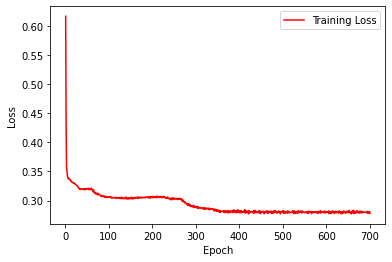

Training loss: 0.38110241293907166


In [7]:
loss_data=[]
epochs = 700
for e in range(epochs):
    running_loss = 0#get images
    for info, labels in train_loader:
        info=info.to(device)
        labels=labels.to(device)
        #Flatten images
        #images=images.view(images.shape[0], -1)
        dummy_labels=labels.float()
        #info=info.reshape(info.shape[0],)
        dummy_labels=dummy_labels.view(-1,1)
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #Forward pass
        output=model(info)
        

        #Calculate the loss
        loss=loss_fn(output,dummy_labels)
        
        
        
        #backward propagation
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    

     ## TODO: Implement the validation pass and print out the validation accuracy
    else:
        #print(f"Training loss: {running_loss/len(train_loader)}") 
        loss_data.append(loss)
        #print('bias',model.linearlinear[0].bias)
        #print('weight',model.linearlinear[0].weight)
        #print("output",output)
        #print("labels",dummy_labels)
        #print('shape',info.shape)
#print("output",output)   

epoch_count = range(1, epochs + 1)

plt.plot(epoch_count, loss_data, 'r')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

print(f"Training loss: {running_loss/len(train_loader)}") 

In [8]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        images=images.cuda()
        labels=labels.cuda()
        outputs = model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network : %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [9]:
labels.view(-1,1)

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]], device='cuda:0', dtype=torch.float64)